Questions :  
- cpt = 0.35 ! si exact erreur(trop extrapolé)   ; sinon 0 restart (her parametre, restart condition façon évaluer les deux couts). 
- error biaisé : nb echantillon petit / grand, influence (ratio vers 6/7 quand grand)  
- Non negative case : non negative least square


TO do :

2. on s'arrete dès qu'il cvg : restart = 0, se rend pas compte assez vite qu'il est sur mauvaise direction
4. mediane (pas la vraie longeur)

In [1]:
pip install -U tensorly

     |████████████████████████████████| 112kB 7.4MB/s 
     |████████████████████████████████| 163kB 7.5MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.1-cp36-none-any.whl size=149171 sha256=fa698180944c19dfd0ce438bee3e62fb82f514e16c80a91b621dbd46553141fb
  Stored in directory: /root/.cache/pip/wheels/88/1e/e7/b9677b2046cc87e17931b4b5781941786d3ee647825ca40ea6
Successfully built tensorly


In [2]:
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
from tensorly.decomposition import sample_khatri_rao
from scipy.optimize import linear_sum_assignment
from statistics import median
import time
import copy

In [3]:
from tensorly.decomposition import parafac

In [4]:
from tensorly.decomposition import randomised_parafac

In [48]:
t_cons = tl.tensor(np.arange(24,dtype='d').reshape((3, 4, 2)))

In [49]:
t_cons[..., 0]

array([[ 0.,  2.,  4.,  6.],
       [ 8., 10., 12., 14.],
       [16., 18., 20., 22.]])

In [ ]:
t_cons[..., 1]

array([[ 1.,  3.,  5.,  7.],
       [ 9., 11., 13., 15.],
       [17., 19., 21., 23.]])

In [ ]:
unfolded = tl.unfold(t_cons, mode=0)
unfolded

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15.],
       [16., 17., 18., 19., 20., 21., 22., 23.]])

In [ ]:
factors=

In [ ]:
rng = tl.random.check_random_state(None)
Zs,indices=tl.decomposition.sample_khatri_rao(factors,n_samples,skip_matrix=0,random_state=rng)

In [ ]:
indices

[array([ 1, 21, 43, 44, 16, 46, 14,  8, 46, 41, 41, 12, 46, 26, 40, 49, 19,
        45, 47, 33, 42, 26, 31,  1, 16, 16,  2, 19,  6,  8, 35, 15, 41, 17,
        17, 44, 48, 21, 32, 30,  8, 14, 32,  0, 10,  4, 16,  3, 11, 17, 15,
        35, 35, 35,  4, 12, 23,  5, 23, 23,  3, 44, 34,  1,  1, 10, 15,  3,
        49, 26,  4, 34, 33, 47, 30, 37, 21, 21, 19, 24, 34,  4, 30, 48,  4,
        13, 25, 33, 39, 38,  4, 31, 47, 16, 36, 29, 27, 35, 30,  9,  2, 10,
        32,  7, 45,  4, 20, 11,  7,  0, 44, 35, 48, 30, 24, 18, 19, 31, 19,
        11, 28, 42,  4,  6, 37, 34, 20, 33, 36, 29, 21, 32, 22, 25, 16, 42,
         8, 13, 24, 21,  3,  2, 31, 26, 48, 21, 17, 43, 19, 15, 14, 36,  9,
         3, 36, 33, 23, 44, 17,  2, 29, 41,  7, 36, 46, 32, 27,  0,  7, 32,
        31, 31, 18,  0,  3, 46,  4, 37, 45, 41,  2, 45, 38, 41, 22, 37, 32,
        36, 20, 43,  8, 16, 47, 12, 41, 17, 31, 23, 39,  4,  3, 15, 36, 27,
        35, 34,  9, 17, 38,  7, 24,  1, 23, 16, 25,  3, 41,  9, 20, 36, 44,
        36, 

# Decomposition

### ALS

In [5]:
# stopping criteria 
def err(tensor,weight,factors): 
  t_tilde=tl.cp_to_tensor((weight,factors)) # transform tensor decomposition (kruskal tensor) to tensor
  return(tl.norm(tensor-t_tilde))

In [6]:
def err_fast(norm_tensor,A,V,W):
  res=sum(sum(V*(np.transpose(A).dot(A))))
  res=res-2*sum(sum(W*A))
  return(np.sqrt(norm_tensor**2+res))

In [7]:
def err_fac(fac,fac_est) :
  weights,fac=tl.cp_normalize((None,fac))
  weights_est,fac_est=tl.cp_normalize((None,fac_est))
  err=0
  for i in range(len(fac)):
    if i==0 : row_ind, col_ind = linear_sum_assignment(-np.dot(np.transpose(fac[i]),fac_est[i]))
    err=err+(tl.norm(fac[i]-fac_est[i][:,col_ind])/tl.norm(fac[i]))
  return (err/len(fac))

In [8]:
def random_init_fac(tensor,rank):
  factors=[]
  for mode in range(tl.ndim(tensor)):
    factors+=[np.random.random((tl.shape(tensor)[mode], rank))] # random on [0,1)
  return factors

In [9]:
def svd_init_fac(tensor,rank) :
  factors=[]
  for mode in range(tl.ndim(tensor)):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) # first rank eigenvectors/values (ascendent)
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  # sometimes we have singular matrix error
    factors+=[u]
  return (factors)

In [10]:
# ALS method to compute tensor decomposition
def als(tensor,rank,factors=None,it_max=100,tol=1e-7,list_factors=False,error_fast=True,time_rec=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  if time_rec == True : list_time=[]
  if list_factors==True : list_fac=[] # list of factor matrices

  if (factors==None): factors=svd_init_fac(tensor,rank)

  weights=None
  it=0
  if list_factors==True : list_fac.append(copy.deepcopy(factors))
  error=[err(tensor,weights,factors)/norm_tensor]
  while (error[len(error)-1]>tol and it<it_max):
    if time_rec == True : tic=time.time() 
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors[i]),factors[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors), n) 
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
    if list_factors==True : list_fac.append(copy.deepcopy(factors))
    it=it+1
    if (error_fast==False) : error.append(err(tensor,weights,factors)/norm_tensor)
    else : error.append(err_fast(norm_tensor,factors[N-1],V,W)/norm_tensor)
    if time_rec == True : 
      toc=time.time() 
      list_time.append(toc-tic)
  # weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if list_factors==True and time_rec==True: return(weights,factors,it,error,list_fac,list_time)
  if time_rec==True : return(weights,factors,it,error,list_time)
  if list_factors==True : return(weights,factors,it,error,list_fac)
  return(weights,factors,it,error)

### her_Als

In [11]:
def her_Als(tensor,rank,factors=None,it_max=100,tol=1e-7,beta=0.5,eta=1.5,gamma=1.05,gamma_bar=1.01,list_factors=False,error_fast=True,time_rec=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  weights=None
  if time_rec == True : list_time=[]
  if list_factors==True : list_fac=[]

  if (factors==None): factors=svd_init_fac(tensor,rank)

  # Initialization of factor hat matrices by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(copy.deepcopy(factors))

  it=0
  # err_it=0
  cpt=0
  F_hat_bf=err(tensor,None,factors) # cost
  error=[F_hat_bf/norm_tensor]
  # min_err=error[len(error)-1]

  while (error[len(error)-1] > tol and it<it_max ):
    if time_rec == True : tic=time.time()
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors_hat[i]),factors_hat[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors_hat), n) 
      factor_bf=factors[n]
      # update
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)

    if (error_fast==False) : F_hat_new = err(tensor,None,factors_hat) # cost update 
    else : F_hat_new = err_fast(norm_tensor,factors[N-1],V,W)
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    F_hat_bf=F_hat_new
    it=it+1
    if list_factors==True : list_fac.append(copy.deepcopy(factors))
    error.append(F_hat_new/norm_tensor)
    #if (error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    #else : err_it=err_it+1
    if time_rec == True : 
      toc=time.time()
      list_time.append(toc-tic)
  # weights,factors=tl.cp_normalize((None,factors))
  if time_rec == True and list_factors==True: return(weights,factors,it,error,cpt/it,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  if time_rec == True : return(weights,factors,it,error,cpt/it,list_time)
  return(weights,factors,it,error,cpt/it)


### CPRAND

#### Stopping criteria

In [12]:
# Stopping criteria of CPRAND
def err_rand(tensor,weights,factors,nb_samples,indices_list=None): 
  if indices_list==None : 
    indices_list = [np.random.randint(0, tl.shape(m)[0], size=nb_samples, dtype=int) for m in factors] 
    indices_list = [i.tolist() for i in indices_list]
    indices_list = tuple(indices_list)
  est_values=[]
  P=1
  for i in tl.shape(tensor) : P=P*i
  for i in range(nb_samples):
     if weights is None : value=1
     else : value=weights
     for mode in range(tl.ndim(tensor)) :
       value=value*factors[mode][indices_list[mode][i],:]
     est_values+=[sum(value)]
  list_e=(tensor[indices_list]-est_values)**2  # max(list_e) = 1 (general ? mais si les donnees sont grandes ?)
  return(np.sqrt(sum(list_e)*P/nb_samples),indices_list) 

In [13]:
def err_rand_fast(tensor,A,V,W,indices_list,nb_samples=None): 
  # randomised tensor norm  
  norm_tensor=tl.norm(tensor[indices_list])
  res=sum(sum(V*(np.transpose(A).dot(A))))
  res=norm_tensor**2+res-2*sum(sum(W*A)) 
  if nb_samples == None : nb_samples = np.shape(indices_list[0])[0]
  res=res/nb_samples
  P=1
  for i in tl.shape(tensor) : P=P*i
  return(np.sqrt(res*P),indices_list) 

In [50]:
# create a kruskal tensor
# factor matrices
A=np.arange(9).reshape(3,3)
B=np.arange(6).reshape(2,3)+9
C=np.arange(6).reshape(2,3)+15
factors=[]
factors+=[A]
factors+=[B]
factors+=[C]
t_krus = tl.cp_to_tensor((None,factors))
weights_cp,factors_cp=tl.cp_normalize((None,factors))


In [58]:
rng = tl.random.check_random_state(None)
Zs,indices=tl.decomposition.sample_khatri_rao(factors,2,skip_matrix=1,random_state=rng)
indices_list = [i.tolist() for i in indices]
indices_list.insert(1, slice(None, None, None))
indices_list = tuple(indices_list)

In [59]:
indices_list

([0, 1], slice(None, None, None), [0, 1])

In [64]:
t_krus[..., 0]

array([[ 534,  684],
       [1980, 2562],
       [3426, 4440]])

In [65]:
t_krus[..., 1]

array([[ 630,  807],
       [2346, 3036],
       [4062, 5265]])

In [61]:
t_krus[indices_list]

array([[ 534,  684],
       [2346, 3036]])

#### Main method

In [ ]:
# version 1 variance trop grande : error comme dans her, mais les matrices V,W et la norme tensor etantes randomisees.
def CPRAND(tensor,rank,n_samples,factors=None,exact_err=False,it_max=100,err_it_max=20,tol=1e-7,list_factors=False,time_rec=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor

  if list_factors==True : list_fac=[]
  if time_rec == True : list_time=[]
  if (factors==None): factors=svd_init_fac(tensor,rank)
  # weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if list_factors==True : list_fac.append(copy.deepcopy(factors))
  weights=None
  it=0
  err_it=0
  ########################################
  ######### error initialization #########
  ########################################
  if (exact_err==False):
    temp,ind_err=err_rand(tensor,weights,factors,400) 
    error=[temp/norm_tensor] 
  else :
    error=[err(tensor,weights,factors)/norm_tensor]

  min_err=error[len(error)-1]
  rng = tl.random.check_random_state(None)
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec == True : tic=time.time()
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      if (n==0) :sampled_unfolding = tensor[indices_list]
      else : sampled_unfolding =tl.transpose(tensor[indices_list])
      V=tl.dot(tl.transpose(Zs),Zs)
      W=tl.dot(sampled_unfolding,Zs)
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared matrix
    

    if list_factors==True : list_fac.append(copy.deepcopy(factors))
    it=it+1

    ################################
    ######### error update #########
    ################################
    if (exact_err==False):
      error.append(err_rand_fast(tensor,factors[N-1],V,W,indices_list,n_samples)[0]/norm_tensor) # same indices used as for Random Lesat Square Calculation
    else : error.append(err(tensor,weights,factors)/norm_tensor)
    
    if (error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec == True : 
      toc=time.time()
      list_time.append(toc-tic)
  # weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if time_rec == True and list_factors==True: return(weights,factors,it,error,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,list_fac)
  if time_rec==True : return(weights,factors,it,error,list_time)
  return(weights,factors,it,error)

In [14]:
# version triche
def CPRAND(tensor,rank,n_samples,factors=None,exact_err=True,it_max=100,err_it_max=20,tol=1e-7,list_factors=False,time_rec=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor

  if list_factors==True : list_fac=[]
  if time_rec == True : list_time=[]
  if (factors==None): factors=svd_init_fac(tensor,rank)
  # weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if list_factors==True : list_fac.append(copy.deepcopy(factors))
  weights=None
  it=0
  err_it=0
  ########################################
  ######### error initialization #########
  ########################################
  temp,ind_err=err_rand(tensor,weights,factors,400) 
  error=[temp/norm_tensor] 
  error_ex=[err(tensor,weights,factors)/norm_tensor]

  min_err=error[len(error)-1]
  rng = tl.random.check_random_state(None)
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec == True : tic=time.time()
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      if (n==0) :sampled_unfolding = tensor[indices_list]
      else : sampled_unfolding =tl.transpose(tensor[indices_list])
      V=tl.dot(tl.transpose(Zs),Zs)
      W=tl.dot(sampled_unfolding,Zs)
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared matrix
    

    if list_factors==True : list_fac.append(copy.deepcopy(factors))
    it=it+1

    ################################
    ######### error update #########
    ################################
    error.append(err_rand_fast(tensor,factors[N-1],V,W,indices_list,n_samples)[0]/norm_tensor) # same indices used as for Random Lesat Square Calculation

    
    if (error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec == True : 
      toc=time.time()
      list_time.append(toc-tic)
    error_ex.append(err(tensor,weights,factors)/norm_tensor)
  weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if time_rec == True and list_factors==True: return(weights,factors,it,error_ex,error,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error_ex,error,list_fac)
  if time_rec==True : return(weights,factors,it,error_ex,error,list_time)
  return(weights,factors,it,error_ex,error)

#### Test

t_krus has 12 terms. If n_samples=33/400, err_rand=1.2*err_exa

In [ ]:
A=np.arange(9).reshape(3,3)
B=np.arange(6).reshape(2,3)+9
C=np.arange(6).reshape(2,3)+15
factors=[]
factors+=[A]
factors+=[B]
factors+=[C]
t_krus = tl.cp_to_tensor((None,factors))

In [ ]:
rank=3
n_samples=int(10*rank*np.log(rank)+1)
# n_samples=400
weights,factors,it,error=CPRAND(t_krus,rank,n_samples,exact_err=False)
it

2

In [ ]:
error[len(error)-1]/(tl.norm(tl.cp_to_tensor((weights,factors))-t_krus)/tl.norm(t_krus))

1.209074128422695

(40,2,2) rank=5, n_samples=81/400, 1 iteration, err_rand=e-8, err_exa=e-15.   
(6,6,6) rank=5, n_samples=81/200/400, err_rand=2 *err_exa  
(10,10,10) rank=5, n_samples=81/400/1000, err_rand=2 *err_exa

In [ ]:
rank=5
n_samples=int(10*rank*np.log(rank)+1)
# n_samples=400

In [ ]:
A,B,C,noise=init_factors(10,10,10,rank)
t=tl.cp_to_tensor((None,[A,B,C]))+noise

In [ ]:
weights,factors,it,error=CPRAND(t,rank,n_samples,exact_err=False)
it

33

In [ ]:
error[len(error)-1]/(tl.norm(tl.cp_to_tensor((weights,factors))-t)/tl.norm(t))

3.01620496279696

### her-CPRAND



#### Main method

In [ ]:
# cpt=0
def her_CPRAND(tensor,rank,n_samples,factors=None,exact_err=False,it_max=100,err_it_max=20,tol=1e-7,beta=0.1,eta=3,gamma=1.01,gamma_bar=1.005,list_factors=False,time_rec=False):
  beta_bar=1
  weights=None
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  if list_factors==True : list_fac=[]
  if (time_rec==True) : list_time=[]

  if (factors==None) : factors=svd_init_fac(tensor,rank)
  # Initialization of factor hat matrice by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(copy.deepcopy(factors))
  if time_rec==True : list_err=[]

  it=0
  err_it=0
  cpt=0
  ########################################
  ######### error initialization #########
  ########################################
  if (exact_err==False):F_hat_bf,ind_bf=err_rand(tensor,None,factors,n_samples)
  else : F_hat_bf=err(tensor,None,factors) # exact cost
  rng = tl.random.check_random_state(None)
  error=[F_hat_bf/norm_tensor]
  min_err=error[len(error)-1]

  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec==True :tic=time.time()
    factors_hat_bf=factors_hat
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors_hat,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      V=tl.dot(tl.transpose(Zs),Zs)
      # J'ai du mal avec la syntaxe tensor[indices_list],
      # Ca renvoie une matrices et non un tenseur?
      if (n==0) :sampled_unfolding = tensor[indices_list] 
      else : sampled_unfolding = tl.transpose(tensor[indices_list])
      W=tl.dot(sampled_unfolding,Zs)
      factor_bf=factors[n]
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared full rank matrix, if rank>nb_sampls ok
      # if (n==N-1) : F_hat_new=tl.norm(tl.dot(Zs,tl.transpose(factors[n]))-sampled_unfolding,2) # cost update 
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)
    ########################################
    #########      error update    #########
    ########################################
    if (exact_err==False): 
      matrices = factors_hat_bf[:-1]
      Zs_bf = tl.ones((n_samples, rank), **tl.context(matrices[0]))
      for indices, matrix in zip(indices_list, matrices): 
        Zs_bf = Zs_bf * matrix[indices, :]
      V_bf=tl.dot(tl.transpose(Zs_bf),Zs_bf)
      W_bf=tl.dot(tl.transpose(tensor[indices_list]),Zs_bf)
      F_hat_bf,a= err_rand_fast(tensor,factor_bf,V_bf,W_bf,indices_list,n_samples)
      F_hat_new,_= err_rand_fast(tensor,factors[N-1],V,W,indices_list,n_samples) 
    else :
      F_hat_new = err(tensor,None,factors_hat) # exact cost update 
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    ########################################
    ######### update for next it   #########
    ########################################
    if (exact_err==True) : F_hat_bf=F_hat_new
    it=it+1
    if list_factors==True : list_fac.append(copy.deepcopy(factors))
    error.append(F_hat_bf/norm_tensor)
    if (error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec==True : 
      toc=time.time()
      list_time.append(toc-tic)
  # weights,factors=tl.cp_normalize((None,factors))
  if list_factors==True and time_rec==True: return(weights,factors,it,error,cpt/it,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  if time_rec==True : return(weights,factors,it,error,cpt/it,list_time)
  return(weights,factors,it,error,cpt/it)

In [15]:
# version triche (rendre erreur exacte et erreur estimee)
def her_CPRAND(tensor,rank,n_samples,factors=None,exact_err=True,it_max=100,err_it_max=20,tol=1e-7,beta=0.1,eta=3,gamma=1.01,gamma_bar=1.005,list_factors=False,time_rec=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  if list_factors==True : list_fac=[]
  if (time_rec==True) : list_time=[]

  if (factors==None) : factors=svd_init_fac(tensor,rank)
  # Initialization of factor hat matrice by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(copy.deepcopy(factors))

  it=0
  err_it=0
  cpt=0
  ########################################
  ######### error initialization #########
  ########################################
  F_hat_bf,ind_bf=err_rand(tensor,None,factors,n_samples)
  F_hat_bf_ex=err(tensor,None,factors) # exact cost
  rng = tl.random.check_random_state(None)
  error=[F_hat_bf/norm_tensor]
  error_ex=[F_hat_bf_ex/norm_tensor]
  min_err=error[len(error)-1]

  while (min_err>tol and it<it_max and err_it<err_it_max): 
    if time_rec==True :tic=time.time()
    factors_hat_bf=factors_hat
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors_hat,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      V=tl.dot(tl.transpose(Zs),Zs)
      # J'ai du mal avec la syntaxe tensor[indices_list],
      # Ca renvoie une matrices et non un tenseur?
      if (n==0) :sampled_unfolding = tensor[indices_list] 
      else : sampled_unfolding = tl.transpose(tensor[indices_list])
      W=tl.dot(sampled_unfolding,Zs)
      factor_bf=factors[n]
      # update
      factors[n] = tl.transpose(tl.solve(V,tl.transpose(W))) # solve needs a squared full rank matrix, if rank>nb_sampls ok
      # if (n==N-1) : F_hat_new=tl.norm(tl.dot(Zs,tl.transpose(factors[n]))-sampled_unfolding,2) # cost update 
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)
    ########################################
    #########      error update    #########
    ########################################

    matrices = factors_hat_bf[:-1]
    Zs_bf = tl.ones((n_samples, rank), **tl.context(matrices[0]))
    for indices, matrix in zip(indices_list, matrices): 
      Zs_bf = Zs_bf * matrix[indices, :]
    V_bf=tl.dot(tl.transpose(Zs_bf),Zs_bf)
    W_bf=tl.dot(tl.transpose(tensor[indices_list]),Zs_bf)
    F_hat_bf,a= err_rand_fast(tensor,factor_bf,V_bf,W_bf,indices_list,n_samples)
    F_hat_new,_= err_rand_fast(tensor,factors[N-1],V,W,indices_list,n_samples) 
 
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    ########################################
    ######### update for next it   #########
    ########################################
    it=it+1
    if list_factors==True : list_fac.append(copy.deepcopy(factors))
    error.append(F_hat_new/norm_tensor)
    if (error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
    if time_rec==True : 
      toc=time.time()
      list_time.append(toc-tic)
    error_ex.append(err(tensor,None,factors)/norm_tensor)  # exact cost update
  weights,factors=tl.cp_normalize((None,factors))
  if list_factors==True and time_rec==True: return(weights,factors,it,error_ex,error,cpt/it,list_fac,list_time)
  if list_factors==True : return(weights,factors,it,error_ex,error,cpt/it,list_fac)
  if time_rec==True : return(weights,factors,it,error_ex,error,cpt/it,list_time)
  return(weights,factors,it,error_ex,error,cpt/it)

#### Test her_CPRAND

In [20]:
rank=5
n_samples=int(10*rank*np.log(rank)+1)
A,B,C,noise=init_factors(10,10,10,rank)
t=tl.cp_to_tensor((None,[A,B,C]))+noise

In [22]:
weights,factors,it,error,err_es,cpt=her_CPRAND(t,rank,n_samples,exact_err=False)
it

38

In [23]:
cpt

0.0

In [ ]:
err_true=tl.norm(tl.cp_to_tensor((weights,factors))-t)/tl.norm(t)
err_true

0.00037132606577760044

In [ ]:
error[len(error)-1]/err_true

2.9426164193194584

In [69]:
A,B,C,noise=init_factors(I,J,K,r,True)
fac_true=[A,B,C]
t=tl.cp_to_tensor((None,fac_true))+noise
factors=random_init_fac(t,r)

In [25]:
weights1,factors1,it1,error1,cpt1=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500) 

In [26]:
cpt1

0.32

In [27]:
weights4,factors4,it4,error4=als(t,r,factors=copy.deepcopy(factors),it_max=500) 

In [70]:
weights2,factors2,it2,error2,error_es1=CPRAND(t,r,n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=400) 

In [ ]:
fac,e=randomised_parafac(t,r,n_samples,500,tol=1e-07,max_stagnation=400,return_errors=True)

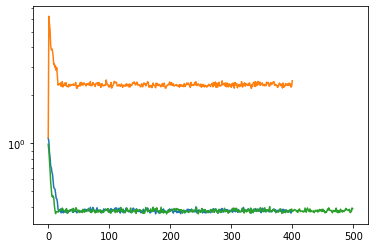

In [72]:
plt.plot(range(len(error2)),error2,label="CPRAND")
plt.plot(range(len(error_es1)),error_es1,label="CPRAND es")
plt.plot(range(len(e)),e,label="CPRAND es")
plt.yscale("log") 

In [76]:
# with estimated error
weights3,factors3,it3,error3,error_es,cpt=her_CPRAND(t,r,n_samples,factors=copy.deepcopy(factors),exact_err=False,it_max=500,err_it_max=400) 

In [39]:
cpt

0.005

In [ ]:
# with exact error
weights3,factors3,it3,error3,cpt=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=400) 

In [ ]:
cpt

0.49047619047619045

Text(0, 0.5, 'f/||X||')

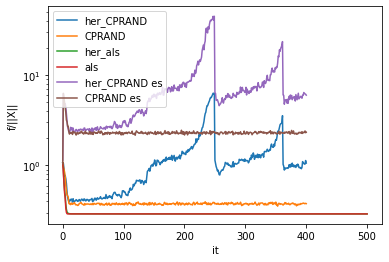

In [47]:
# exact error
plt.plot(range(len(error3)),error3,label="her_CPRAND")
plt.plot(range(len(error2)),error2,label="CPRAND")
plt.plot(range(len(error1)),error1,label="her_als")
plt.plot(range(len(error4)),error4,label="als")
plt.plot(range(len(error_es)),error_es,label="her_CPRAND es")
plt.plot(range(len(error_es1)),error_es1,label="CPRAND es")
plt.yscale("log") 
plt.legend(loc='best')
plt.xlabel('it')
plt.ylabel('f/||X||')

In [86]:
weights3,factors3,it3,error3,error_es,cpt=her_CPRAND(t,r,n_samples,factors=copy.deepcopy(factors),exact_err=False,it_max=500,err_it_max=400) 

In [87]:
error_peu=error3
err_es_peu=error_es

In [88]:
weights3,factors3,it3,error5,error_es2,cpt=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=False,it_max=500,err_it_max=400) 

In [89]:
error_bcp=error5
err_es_bcp=error_es2

Text(0, 0.5, 'f/||X||')

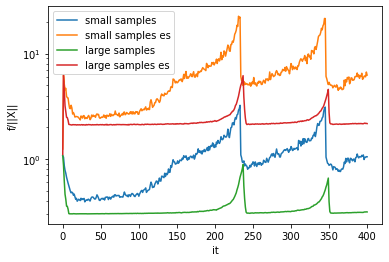

In [91]:
plt.plot(range(len(error_peu)),error_peu,label="small samples")
plt.plot(range(len(err_es_peu)),err_es_peu,label="small samples es")
plt.plot(range(len(error_bcp)),error_bcp,label="large samples")
plt.plot(range(len(err_es_bcp)),err_es_bcp,label="large samples es")
plt.yscale("log") 
plt.legend(loc='best')
plt.xlabel('it')
plt.ylabel('f/||X||')

In [ ]:
error_bcp=error_es

In [ ]:
error_peu=error_es

Text(0, 0.5, 'f/||X||')

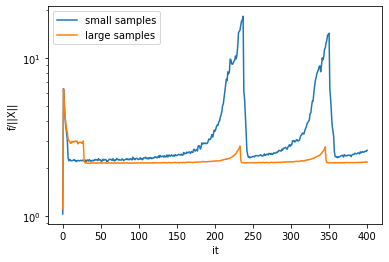

In [ ]:
plt.plot(range(len(error_peu)),error_peu,label="small samples")
plt.plot(range(len(error_bcp)),error_bcp,label="large samples")
plt.yscale("log") 
plt.legend(loc='best')
plt.xlabel('it')
plt.ylabel('f/||X||')

In [ ]:
min(error4)

0.2895578730732859

In [ ]:
cpt

0.005

In [ ]:
min(error3)

0.3795793244762621

In [ ]:
min(error3)

0.31196979465622016

In [ ]:
norm_tensor=tl.norm(t)
error1=[i * norm_tensor for i in error1]
error2=[i * norm_tensor for i in error2]
error3=[i * norm_tensor for i in error3]
error4=[i * norm_tensor for i in error4]

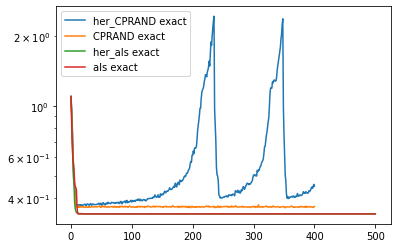

In [ ]:

# exact error
plt.plot(range(len(error3)),error3,label="her_CPRAND exact")
plt.plot(range(len(error2)),error2,label="CPRAND exact")
plt.plot(range(len(error1)),error1,label="her_als exact")
plt.plot(range(len(error4)),error4,label="als exact")
#plt.plot(range(len(error_es)),error_es,label="her_CPRAND es")
#plt.plot(range(len(e)),e,label="CPRAND tl")
plt.yscale("log") 
plt.legend(loc='best')

In [ ]:
list_err1=[]
list_err2=[]
list_err3=[]
list_err4=[]

In [ ]:
list_err1.append(error1)
list_err2.append(error2)
list_err3.append(error3)
list_err4.append(error4)

In [ ]:
min_e=min(min(error1),min(error2),min(error3),min(error4),min_e)

In [ ]:
error2

In [ ]:
list_err1=np.array([np.array(i)  for i in list_err1])
list_err2=np.array([np.array(i)  for i in list_err2])
list_err3=np.array([np.array(i)  for i in list_err3])
list_err4=np.array([np.array(i)  for i in list_err4])
list_err1=list_err1-min_e
list_err2=list_err2-min_e
list_err3=list_err3-min_e
list_err4=list_err4-min_e

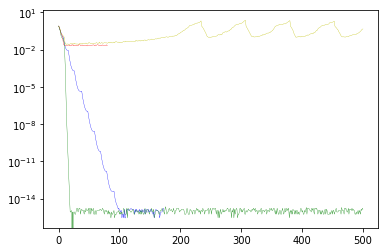

In [ ]:
for i in list_err1:
  plt.plot(range(len(i)),i,'b-',linewidth=.3) 
for i in list_err2:
  plt.plot(range(len(i)),i,'r-',linewidth=.3) 
for i in list_err3:
  plt.plot(range(len(i)),i,'y-',linewidth=.3) 
for i in list_err4:
  plt.plot(range(len(i)),i,'g-',linewidth=.3) 
plt.yscale("log") 


In [ ]:
pct

0.008

In [104]:
ratio=[]
for i in range(400):
  ratio.append(error_es2[i]/error5[i])

Text(0.5, 1.0, 'error es/err large sample')

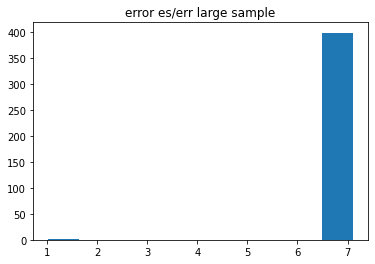

In [105]:
plt.hist(ratio)
plt.title("error es/err large sample")

#### param research

In [ ]:
def param_research(I,J,K,r,nb_rand,n_samples,exact_err=True,beta=True,eta=False,gamma=False):
  list_err1=[]
  list_err2=[]
  list_err3=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    A=np.random.normal(0, 1, size=(I, r))
    B=np.random.normal(0, 1, size=(J, r))
    C=np.random.normal(0, 1, size=(K, r))
    noise=np.random.normal(0, 0.001, size=(I,J,K))
    tensor=tl.cp_to_tensor((None,[A,B,C]))+noise
    norm_tensor=tl.norm(tensor,2)
    if(min_e==None) : min_e=norm_tensor
    # parameter choice
    if(beta==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.1) # beta0=0.1
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.3) # beta0=0.3
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.5) # beta0=0.5
    if(eta==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=1.1) # eta=1.1
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=2) # eta=2
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=3) # eta=3
    if(gamma==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.01,gamma_bar=1.005) 
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.05,gamma_bar=1.01) 
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.9,gamma_bar=1.5) 
    error1=[i * norm_tensor for i in error1]
    list_err1.append(error1)
    error2=[i * norm_tensor for i in error2]
    list_err2.append(error2)
    error3=[i * norm_tensor for i in error3]
    list_err3.append(error3)
    if (min_e>min(min(error1),min(error2),min(error3))) : min_e=min(min(error1),min(error2),min(error3))
  list_err1=[x-min_e for x in list_err1]
  list_err2=[x-min_e for x in list_err2]
  list_err3=[x-min_e for x in list_err3]
  # plot
  for i in range(len(list_err1)):
    if i==0 : plt.plot(range(len(list_err1[i])),list_err1[i],'b-',label='eta=1.1') 
    else: plt.plot(range(len(list_err1[i])),list_err1[i],'b-') 
    
  for i in range(len(list_err2)):
    if i==0: plt.plot(range(len(list_err2[i])),list_err2[i],'r-',label='eta=2') 
    else : plt.plot(range(len(list_err2[i])),list_err2[i],'r-') 
    
  for i in range(len(list_err3)):
    if i==0 : plt.plot(range(len(list_err3[i])),list_err3[i],'g-',label='eta=3')
    else : plt.plot(range(len(list_err3[i])),list_err3[i],'g-')
  plt.yscale("log") 
  plt.legend(loc='best')
  plt.xlabel('it')
  plt.ylabel('f')
  plt.title('f(iteration)')

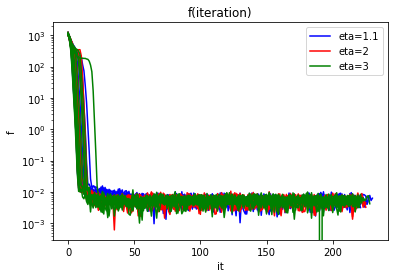

In [ ]:
param_research(I,J,K,r,nb_rand,n_samples,beta=False,eta=True,exact_err=True)

# Comparaison of algorithms

In [16]:
def sv_scale_to_100(A):
  u,d,v=np.linalg.svd(A,full_matrices=False)
  scale=99/(d[0]-d[len(d)-1])
  for i in range(len(d)) : d[i]=(d[i]-d[len(d)-1])*scale+1
  d[len(d)-1]=1
  return (u@np.diag(d)@v)

In [17]:
def init_factors(I,J,K,r,noise_level=0.001,scale=False) :
  A=np.random.normal(0, 1, size=(I, r))
  B=np.random.normal(0, 1, size=(J, r))
  C=np.random.normal(0, 1, size=(K, r))
  noise=np.random.normal(0, noise_level, size=(I,J,K))
  if (scale==True) :  
    A=sv_scale_to_100(A)
    B=sv_scale_to_100(B)
    C=sv_scale_to_100(C)
  return (A,B,C,noise)

#### Iterations

##### 3 algorithms for 10 random initializations

In [25]:
# plot the median of data fitting/factors error over nb_rand initializations
def comparaison(I,J,K,r,nb_rand,n_samples,exact_err=False,list_factors=False,scale=False):
  list_err1=[]
  list_err2=[]
  list_err3=[]
  list_err4=[]
  list_pct=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    # np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale)
    fac_true=[A,B,C]
    t=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(t,2)
    if(min_e==None) : min_e=norm_tensor
    for k in range(5):
      factors=random_init_fac(t,r)   
      if list_factors ==False : 
        weights4,factors4,it4,error4,_,cpt1=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250) 
        weights1,factors1,it1,error1,cpt=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500) 
        weights3,factors3,it3,error3,_=CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250) 
        weights2,factors2,it2,error2=als(t,r,factors=copy.deepcopy(factors),it_max=500) 
        error1=[i * norm_tensor for i in error1]
        error2=[i * norm_tensor for i in error2]
        error3=[i * norm_tensor for i in error3]
        error4=[i * norm_tensor for i in error4]
      else : 
        weights4,factors4,it4,error,_,cpt1,l4=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250,list_factors=list_factors) 
        weights1,factors1,it1,error,cpt,l1=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500,list_factors=list_factors) 
        weights3,factors3,it3,error,_,l3=CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250,list_factors=list_factors) 
        weights2,factors2,it2,error,l2=als(t,r,factors=copy.deepcopy(factors),it_max=500,list_factors=list_factors) 
        error1=[err_fac(fac_true,i) for i in l1]
        error2=[err_fac(fac_true,i) for i in l2]
        error3=[err_fac(fac_true,i) for i in l3]
        error4=[err_fac(fac_true,i) for i in l4]
      list_pct.append(cpt1)
      if (min_e>min(min(error1),min(error2),min(error3),min(error4))) : min_e=min(min(error1),min(error2),min(error3),min(error4))
      list_err1.append(error1)
      list_err2.append(error2)
      list_err3.append(error3)
      list_err4.append(error4)
  list_err1=np.array([np.array(i)  for i in list_err1])
  list_err2=np.array([np.array(i)  for i in list_err2])
  list_err3=np.array([np.array(i)  for i in list_err3])
  list_err4=np.array([np.array(i)  for i in list_err4])
  list_err1=list_err1-min_e
  list_err2=list_err2-min_e
  list_err3=list_err3-min_e
  list_err4=list_err4-min_e
  for i in list_err1:
    plt.plot(range(len(i)),i,'b-',linewidth=.3) 
  for i in list_err2:
    plt.plot(range(len(i)),i,'r-',linewidth=.3) 
  for i in list_err3:
    plt.plot(range(len(i)),i,'y-',linewidth=.3) 
  for i in list_err4:
    plt.plot(range(len(i)),i,'g-',linewidth=.3) 
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  n_max3=len(max(list_err3, key=len))
  n_max4=len(max(list_err4, key=len))
  mat1=np.array([i.tolist() + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i.tolist() + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat3=np.array([i.tolist() + [i[len(i)-1]]*(n_max3-len(i)) for i in list_err3])
  mat4=np.array([i.tolist() + [i[len(i)-1]]*(n_max4-len(i)) for i in list_err4])
  
  # plot
  plt.plot(range(n_max1),np.median(mat1, axis=0),'b-',linewidth=3,label="her_als") 
  plt.plot(range(n_max2),np.median(mat2, axis=0),'r-',linewidth=3,label="als") 
  plt.plot(range(n_max3),np.median(mat3, axis=0),'y-',linewidth=3,label="CPRAND") 
  plt.plot(range(n_max4),np.median(mat4, axis=0),'g-',linewidth=3,label="herCPRAND") 
  plt.yscale("log") 
  plt.xlabel('it')
  plt.ylabel('factor error')
  plt.legend(loc='best')
  plt.title('Complicated case exact error')


In [38]:
# version ancienne
def comparaison(I,J,K,r,nb_rand,n_samples,exact_err=False,list_factors=False,scale=False):
  list_err1=[]
  list_err2=[]
  list_err3=[]
  list_err4=[]
  list_pct=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale)
    fac_true=[A,B,C]
    t=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(t,2)
    if(min_e==None) : min_e=norm_tensor
    for k in range(5):
      factors=random_init_fac(t,r)   
      if list_factors ==False : 
        weights4,factors4,it4,error4,_,cpt1=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250) 
        weights1,factors1,it1,error1,cpt=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500) 
        weights3,factors3,it3,error3,_=CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250) 
        weights2,factors2,it2,error2=als(t,r,factors=copy.deepcopy(factors),it_max=500) 
        error1=[i * norm_tensor for i in error1]
        error2=[i * norm_tensor for i in error2]
        error3=[i * norm_tensor for i in error3]
        error4=[i * norm_tensor for i in error4]
      else : 
        weights4,factors4,it4,error,_,cpt1,l4=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250,list_factors=list_factors) 
        weights1,factors1,it1,error,cpt,l1=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500,list_factors=list_factors) 
        weights3,factors3,it3,error,_,l3=CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250,list_factors=list_factors) 
        weights2,factors2,it2,error,l2=als(t,r,factors=copy.deepcopy(factors),it_max=500,list_factors=list_factors) 
        error1=[err_fac(fac_true,i) for i in l1]
        error2=[err_fac(fac_true,i) for i in l2]
        error3=[err_fac(fac_true,i) for i in l3]
        error4=[err_fac(fac_true,i) for i in l4]
      list_pct.append(cpt1)
      if (min_e>min(min(error1),min(error2),min(error3),min(error4))) : min_e=min(min(error1),min(error2),min(error3),min(error4))
      list_err1.append(error1)
      list_err2.append(error2)
      list_err3.append(error3)
      list_err4.append(error4)
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  n_max3=len(max(list_err3, key=len))
  n_max4=len(max(list_err4, key=len))
  mat1=np.array([i + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat3=np.array([i + [i[len(i)-1]]*(n_max3-len(i)) for i in list_err3])
  mat4=np.array([i + [i[len(i)-1]]*(n_max4-len(i)) for i in list_err4])
  mat1=mat1-min_e
  mat2=mat2-min_e
  mat3=mat3-min_e
  mat4=mat4-min_e
  # plot

  plt.plot(range(n_max1),np.median(mat1, axis=0),'b-',label="her_als") 
  plt.plot(range(n_max2),np.median(mat2, axis=0),'r-',label="als") 
  plt.plot(range(n_max3),np.median(mat3, axis=0),'y-',label="CPRAND") 
  plt.plot(range(n_max4),np.median(mat4, axis=0),'g-',label="herCPRAND") 
  plt.yscale("log") 
  plt.xlabel('it')
  plt.ylabel('factor error')
  plt.legend(loc='best')
  plt.title('Simple case')

In [21]:
I=50
J=50
K=50
r=10 # rank
n_samples=int(10*r*np.log(r)+1) # nb of randomized samples
nb_rand=10 # nb of random initialization

##### Simple case

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of l

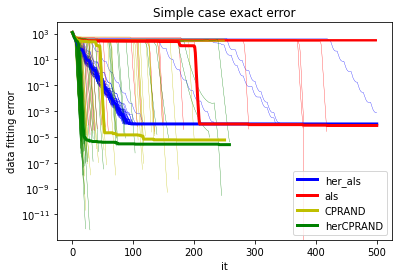

In [22]:
# data fitting error
comparaison(I,J,K,r,nb_rand,n_samples)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


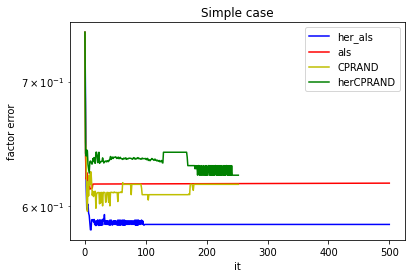

In [39]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,False,list_factors=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/py

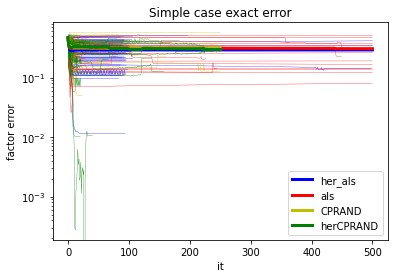

In [24]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,False,list_factors=True)

##### More complicated case

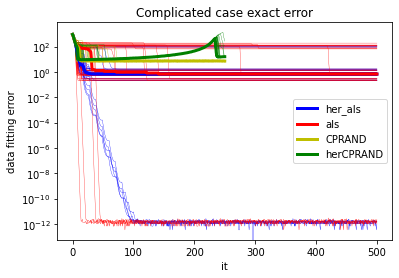

In [110]:
# data fitting error
comparaison(I,J,K,r,nb_rand,n_samples,scale=True)

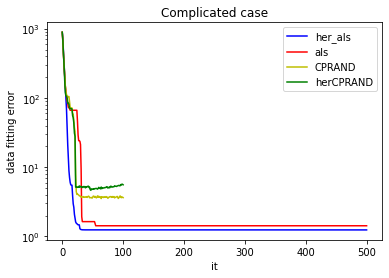

In [ ]:
# data fitting error
comparaison(I,J,K,r,nb_rand,n_samples,scale=True)

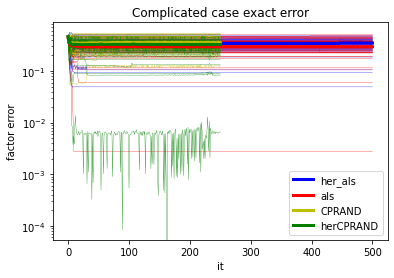

In [26]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,False,list_factors=True,scale=True)

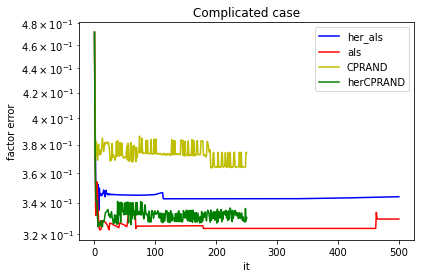

In [37]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,False,list_factors=True,scale=True)

#### Time

##### 3 algorithms for 10 tensors

In [49]:
def compar_time(I,J,K,r,nb_rand,n_samples,exact_err=False,list_factors=False,scale=False):
  list_err1=[]
  list_time1=[]
  list_err2=[]
  list_time2=[]
  list_err3=[]
  list_time3=[]
  list_err4=[]
  list_time4=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale)
    fac_true=[A,B,C]
    t=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(t,2)
    if(min_e==None) : min_e=norm_tensor
    for k in range(5):
      factors=random_init_fac(t,r)
      if list_factors ==False : 
        weights4,factors4,it4,error4,_,cpt,time4=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=100,time_rec=True) 
        weights1,factors1,it1,error1,cpt,time1=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500,time_rec=True) 
        weights3,factors3,it3,error3,_,time3=CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=100,time_rec=True) 
        weights2,factors2,it2,error2,time2=als(t,r,factors=copy.deepcopy(factors),it_max=500,time_rec=True) 
        error1=[i * norm_tensor for i in error1]
        del error1[0]
        error2=[i * norm_tensor for i in error2]
        del error2[0]
        error3=[i * norm_tensor for i in error3]
        del error3[0]
        error4=[i * norm_tensor for i in error4]
        del error4[0]
      else : 
        weights4,factors4,it4,error,_,cpt,l4,time4=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=100,list_factors=list_factors,time_rec=True) 
        weights1,factors1,it1,error,cpt,l1,time1=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500,list_factors=list_factors,time_rec=True) 
        weights3,factors3,it3,error,_,l3,time3=CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=100,list_factors=list_factors,time_rec=True) 
        weights2,factors2,it2,error,l2,time2=als(t,r,factors=copy.deepcopy(factors),it_max=500,list_factors=list_factors,time_rec=True) 
        error1=[err_fac(fac_true,i) for i in l1]
        del error1[0]
        error2=[err_fac(fac_true,i) for i in l2]
        del error2[0]
        error3=[err_fac(fac_true,i) for i in l3]
        del error3[0]
        error4=[err_fac(fac_true,i) for i in l4]
        del error4[0]
      if (min_e>min(min(error1),min(error2),min(error3),min(error4))) : min_e=min(min(error1),min(error2),min(error3),min(error4))
      list_err1.append(error1)
      list_err2.append(error2)
      list_err3.append(error3)
      list_err4.append(error4)
      list_time1.append(time1)
      list_time2.append(time2)
      list_time3.append(time3)
      list_time4.append(time4)
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  n_max3=len(max(list_err3, key=len))
  n_max4=len(max(list_err4, key=len))
  mat1=np.array([i + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat3=np.array([i + [i[len(i)-1]]*(n_max3-len(i)) for i in list_err3])
  mat4=np.array([i + [i[len(i)-1]]*(n_max4-len(i)) for i in list_err4])
  mat1=mat1-min_e
  mat2=mat2-min_e
  mat3=mat3-min_e
  mat4=mat4-min_e

  t_max1=len(max(list_time1, key=len))
  t_max2=len(max(list_time2, key=len))
  t_max3=len(max(list_time3, key=len))
  t_max4=len(max(list_time4, key=len))
  mat_time1=np.array([i + [0]*(t_max1-len(i)) for i in list_time1])
  mat_time2=np.array([i + [0]*(t_max2-len(i)) for i in list_time2])
  mat_time3=np.array([i + [0]*(t_max3-len(i)) for i in list_time3])
  mat_time4=np.array([i + [0]*(t_max4-len(i)) for i in list_time4])
  # plot

  plt.plot(np.cumsum(np.median(mat_time1, axis=0)),np.median(mat1, axis=0),'b-',label="her als") 
  plt.plot(np.cumsum(np.median(mat_time2, axis=0)),np.median(mat2, axis=0),'r-',label="als") 
  plt.plot(np.cumsum(np.median(mat_time3, axis=0)),np.median(mat3, axis=0),'y-',label="CPRAND") 
  plt.plot(np.cumsum(np.median(mat_time4, axis=0)),np.median(mat4, axis=0),'g-',label="herCPRAND") 
  plt.yscale("log") 
  plt.xlabel('time')
  plt.ylabel('data fitting error')
  plt.legend(loc='best')
  plt.title('Simple case')  



In [41]:
# nouvelle version
def compar_time(I,J,K,r,nb_rand,n_samples,exact_err=False,list_factors=False,scale=False):
  list_err1=[]
  list_time1=[]
  list_err2=[]
  list_time2=[]
  list_err3=[]
  list_time3=[]
  list_err4=[]
  list_time4=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale)
    fac_true=[A,B,C]
    t=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(t,2)
    if(min_e==None) : min_e=norm_tensor
    for k in range(5):
      factors=random_init_fac(t,r)
      if list_factors ==False : 
        weights4,factors4,it4,error4,_,cpt,time4=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250,time_rec=True) 
        weights1,factors1,it1,error1,cpt,time1=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500,time_rec=True) 
        weights3,factors3,it3,error3,_,time3=CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250,time_rec=True) 
        weights2,factors2,it2,error2,time2=als(t,r,factors=copy.deepcopy(factors),it_max=500,time_rec=True) 
        error1=[i * norm_tensor for i in error1]
        del error1[0]
        error2=[i * norm_tensor for i in error2]
        del error2[0]
        error3=[i * norm_tensor for i in error3]
        del error3[0]
        error4=[i * norm_tensor for i in error4]
        del error4[0]
      else : 
        weights4,factors4,it4,error,_,cpt,l4,time4=her_CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250,list_factors=list_factors,time_rec=True) 
        weights1,factors1,it1,error,cpt,l1,time1=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500,list_factors=list_factors,time_rec=True) 
        weights3,factors3,it3,error,_,l3,time3=CPRAND(t,r,10*n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=250,list_factors=list_factors,time_rec=True) 
        weights2,factors2,it2,error,l2,time2=als(t,r,factors=copy.deepcopy(factors),it_max=500,list_factors=list_factors,time_rec=True) 
        error1=[err_fac(fac_true,i) for i in l1]
        del error1[0]
        error2=[err_fac(fac_true,i) for i in l2]
        del error2[0]
        error3=[err_fac(fac_true,i) for i in l3]
        del error3[0]
        error4=[err_fac(fac_true,i) for i in l4]
        del error4[0]
      if (min_e>min(min(error1),min(error2),min(error3),min(error4))) : min_e=min(min(error1),min(error2),min(error3),min(error4))
      list_err1.append(error1)
      list_err2.append(error2)
      list_err3.append(error3)
      list_err4.append(error4)
      list_time1.append(time1)
      list_time2.append(time2)
      list_time3.append(time3)
      list_time4.append(time4)
  list_err1=np.array([np.array(i)  for i in list_err1])
  list_err2=np.array([np.array(i)  for i in list_err2])
  list_err3=np.array([np.array(i)  for i in list_err3])
  list_err4=np.array([np.array(i)  for i in list_err4])
  list_err1=list_err1-min_e
  list_err2=list_err2-min_e
  list_err3=list_err3-min_e
  list_err4=list_err4-min_e
  for i in range(len(list_err1)):
    plt.plot(np.cumsum(list_time1[i]),list_err1[i],'b-',linewidth=.3) 
  for i in range(len(list_err2)):
    plt.plot(np.cumsum(list_time2[i]),list_err2[i],'r-',linewidth=.3) 
  for i in range(len(list_err3)):
    plt.plot(np.cumsum(list_time3[i]),list_err3[i],'y-',linewidth=.3) 
  for i in range(len(list_err4)):
    plt.plot(np.cumsum(list_time4[i]),list_err4[i],'g-',linewidth=.3) 
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  n_max3=len(max(list_err3, key=len))
  n_max4=len(max(list_err4, key=len))
  mat1=np.array([i.tolist() + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i.tolist() + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat3=np.array([i.tolist() + [i[len(i)-1]]*(n_max3-len(i)) for i in list_err3])
  mat4=np.array([i.tolist() + [i[len(i)-1]]*(n_max4-len(i)) for i in list_err4])
  

  t_max1=len(max(list_time1, key=len))
  t_max2=len(max(list_time2, key=len))
  t_max3=len(max(list_time3, key=len))
  t_max4=len(max(list_time4, key=len))
  mat_time1=np.array([i + [0]*(t_max1-len(i)) for i in list_time1])
  mat_time2=np.array([i + [0]*(t_max2-len(i)) for i in list_time2])
  mat_time3=np.array([i + [0]*(t_max3-len(i)) for i in list_time3])
  mat_time4=np.array([i + [0]*(t_max4-len(i)) for i in list_time4])
  # plot

  plt.plot(np.cumsum(np.median(mat_time1, axis=0)),np.median(mat1, axis=0),'b-',linewidth=3,label="her als") 
  plt.plot(np.cumsum(np.median(mat_time2, axis=0)),np.median(mat2, axis=0),'r-',linewidth=3,label="als") 
  plt.plot(np.cumsum(np.median(mat_time3, axis=0)),np.median(mat3, axis=0),'y-',linewidth=3,label="CPRAND") 
  plt.plot(np.cumsum(np.median(mat_time4, axis=0)),np.median(mat4, axis=0),'g-',linewidth=3,label="herCPRAND") 
  plt.yscale("log") 
  plt.xlabel('time')
  plt.ylabel('data fitting error')
  plt.legend(loc='best')
  plt.title('Complicated case exact')  


###### Simple case

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of l

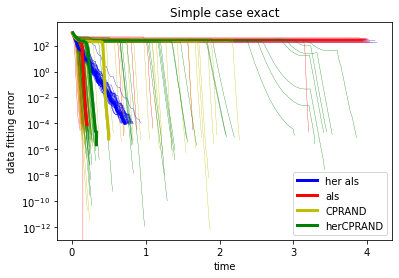

In [33]:
# data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


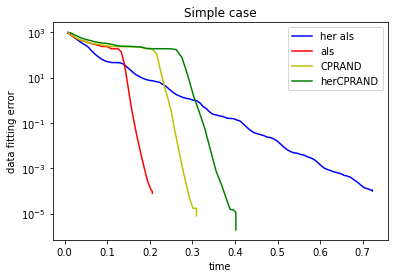

In [50]:
# data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


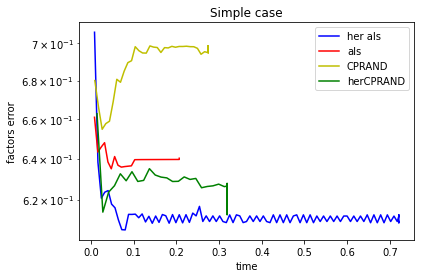

In [48]:
# factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


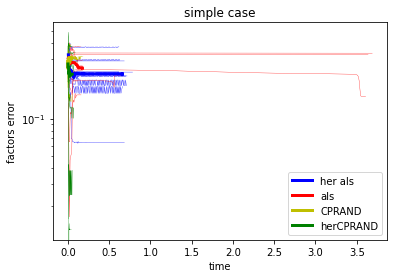

In [ ]:
# factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True)

###### More complicated case

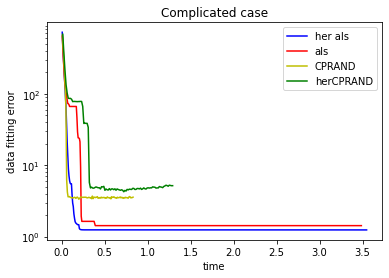

In [ ]:
# data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples,scale=True)

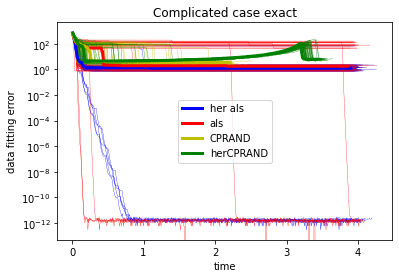

In [42]:
# data fitting error 
compar_time(I,J,K,r,nb_rand,n_samples,scale=True)

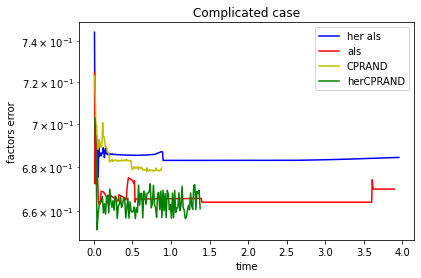

In [44]:
# factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True,scale=True)

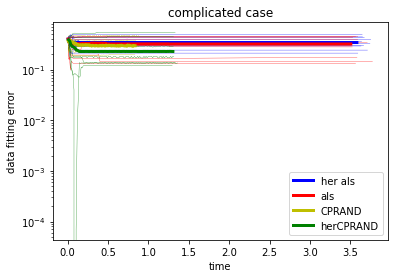

In [ ]:
# factors error 
compar_time(I,J,K,r,nb_rand,n_samples,list_factors=True,scale=True)

# Number of restart

## Simple case with exact error

In [ ]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=False)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    factors=random_init_fac(t,r)
    weights,factors,it,error,pct=her_CPRAND(t,r,n_samples,factors=factors,exact_err=True,it_max=500,err_it_max=100) 
    list_pct.append(pct)
np.mean(list_pct)

0.43622455407900673

In [ ]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=False)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    factors=random_init_fac(t,r)
    weights,factors,it,error,pct=her_Als(t,r,factors=factors,it_max=500) 
    list_pct.append(pct)
median(list_pct)

0.312

## Simple case with estimated error

In [ ]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=False)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    factors=random_init_fac(t,r)
    weights,factors,it,error,pct=her_CPRAND(t,r,n_samples,factors=factors,exact_err=False,it_max=500,err_it_max=100) 
    list_pct.append(pct)
np.mean(list_pct)

0.0

## Complicated case with exact error

In [ ]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=True)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    factors=random_init_fac(t,r)
    weights,factors,it,error,pct=her_CPRAND(t,r,10*n_samples,factors=factors,exact_err=True,it_max=500,err_it_max=100) 
    list_pct.append(pct)
np.mean(list_pct)

0.3435475536640949

In [ ]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=True)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    factors=random_init_fac(t,r)
    weights,factors,it,error,pct=her_Als(t,r,factors=factors,it_max=500) 
    list_pct.append(pct)
median(list_pct)

0.319

## Complicated case with estimated error

In [ ]:
list_pct=[]
for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    np.random.seed(i)
    A,B,C,noise=init_factors(I,J,K,r,scale=True)
    t=tl.cp_to_tensor((None,[A,B,C]))+noise
    factors=random_init_fac(t,r)
    weights,factors,it,error,pct=her_CPRAND(t,r,10*n_samples,factors=factors,exact_err=False,it_max=500,err_it_max=400) 
    list_pct.append(pct)
np.mean(list_pct)

0.005080738488478885

# Real data

## Decomposition

In [ ]:
from google.colab import files
files.upload()

Saving amino.mat to amino.mat


{'amino.mat': b'\x01\x00\x00\x00\x01\x00\x00\x00\xe5\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00evalme\x00\x00\x00\x00\x00\x00\x00Y@\x00\x00\x00\x00\x00@Y@\x00\x00\x00\x00\x00\x00[@\x00\x00\x00\x00\x00\x00]@\x00\x00\x00\x00\x00@X@\x00\x00\x00\x00\x00\x80N@\x00\x00\x00\x00\x00@Z@\x00\x00\x00\x00\x00\x80[@\x00\x00\x00\x00\x00\x00\\@\x00\x00\x00\x00\x00@]@\x00\x00\x00\x00\x00\x00]@\x00\x00\x00\x00\x00\x00D@\x00\x00\x00\x00\x00\x80C@\x00\x00\x00\x00\x00\x00@@\x00\x00\x00\x00\x00\x00R@\x00\x00\x00\x00\x00\xc0[@\x00\x00\x00\x00\x00\xc0]@\x00\x00\x00\x00\x00\x00@@\x00\x00\x00\x00\x00@[@\x00\x00\x00\x00\x00@X@\x00\x00\x00\x00\x00\x80[@\x00\x00\x00\x00\x00@^@\x00\x00\x00\x00\x00\x00@@\x00\x00\x00\x00\x00\x80[@\x00\x00\x00\x00\x00@[@\x00\x00\x00\x00\x00\x00@@\x00\x00\x00\x00\x00@X@\x00\x00\x00\x00\x00\x80X@\x00\x00\x00\x00\x00\xc0[@\x00\x00\x00\x00\x00\x80]@\x00\x00\x00\x00\x00@Y@\x00\x00\x00\x00\x00\x00@@\x00\x00\x00\x00\x00@Y@\x00\x00\x00\x00\x00\x00^@\x00\x00\x00\x00\x00\xc0X@\x00\x00\x00\x00

In [ ]:
import scipy.io
mat = scipy.io.loadmat("amino.mat")

In [ ]:
X=mat['X']

In [ ]:
np.shape(X)

(5, 12261)

In [ ]:
X=np.reshape(X,(5,61,201))

In [ ]:
t=tl.tensor(X)

In [ ]:
exact_err=True
r=3
n_samples=10*int(10*r*np.log(r)+1)
factors=random_init_fac(t,r)
weights4,factors4,it4,error4,cpt=her_CPRAND(t,r,n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=100) 
weights1,factors1,it1,error1=als(t,r,factors=copy.deepcopy(factors),it_max=500) 

In [ ]:
weights2,factors2,it2,error2,cpt2=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500) 

In [ ]:
cpt2

0.354

In [ ]:
cpt

0.35185185185185186

Text(0, 0.5, 'Quantity')

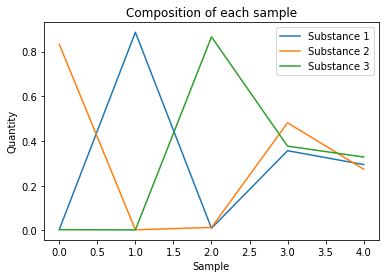

In [ ]:
i=factors4[0]
plt.plot(abs(i[:,0]),label="Substance 1")
plt.plot(abs(i[:,1]),label="Substance 2")
plt.plot(abs(i[:,2]),label="Substance 3")
plt.legend(loc='best')
plt.title("Composition of each sample")
plt.xlabel('Sample')
plt.ylabel('Quantity')

Text(0, 0.5, 'Loading')

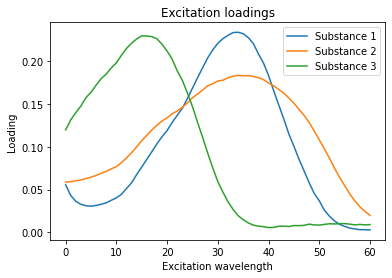

In [ ]:
i=factors4[1]
plt.plot(abs(i[:,0]),label="Substance 1")
plt.plot(abs(i[:,1]),label="Substance 2")
plt.plot(abs(i[:,2]),label="Substance 3")
plt.legend(loc='best')
plt.title("Excitation loadings")
plt.xlabel('Excitation wavelength')
plt.ylabel('Loading')

Text(0, 0.5, 'Loading')

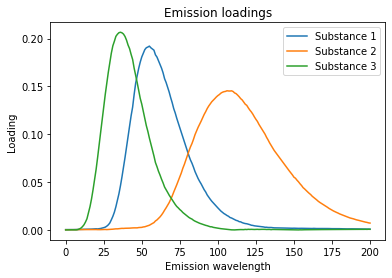

In [ ]:
i=factors4[2]
plt.plot(abs(i[:,0]),label="Substance 1")
plt.plot(abs(i[:,1]),label="Substance 2")
plt.plot(abs(i[:,2]),label="Substance 3")
plt.legend(loc='best')
plt.title("Emission loadings")
plt.xlabel('Emission wavelength')
plt.ylabel('Loading')

## it

Text(0.5, 1.0, 'Real data')

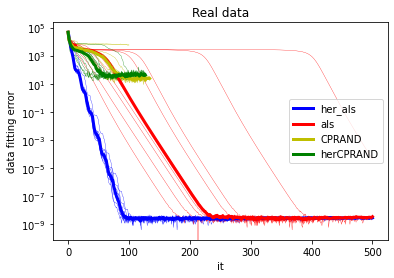

In [ ]:
exact_err=False
r=3
n_samples=10*int(10*r*np.log(r)+1)
list_err1=[]
list_err2=[]
list_err3=[]
list_err4=[]
min_e=None
for i in range(nb_rand) : 
  # Random initialization of a noised cp_tensor
  norm_tensor=tl.norm(t,2)
  if(min_e==None) : min_e=norm_tensor
  factors=random_init_fac(t,r)   

  weights4,factors4,it4,error4,_,cpt=her_CPRAND(t,r,n_samples,factors=copy.deepcopy(factors),exact_err=exact_err,it_max=500,err_it_max=100) 
  weights1,factors1,it1,error1,cpt=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500) 
  weights3,factors3,it3,error3,_=CPRAND(t,r,n_samples,factors=copy.deepcopy(factors),exact_err=exact_err,it_max=500,err_it_max=100) 
  weights2,factors2,it2,error2=als(t,r,factors=copy.deepcopy(factors),it_max=500) 
  error1=[i * norm_tensor for i in error1]
  error2=[i * norm_tensor for i in error2]
  error3=[i * norm_tensor for i in error3]
  error4=[i * norm_tensor for i in error4]

  if (min_e>min(min(error1),min(error2),min(error3),min(error4))) : min_e=min(min(error1),min(error2),min(error3),min(error4))
  list_err1.append(error1)
  list_err2.append(error2)
  list_err3.append(error3)
  list_err4.append(error4)
list_err1=np.array([np.array(i)  for i in list_err1])
list_err2=np.array([np.array(i)  for i in list_err2])
list_err3=np.array([np.array(i)  for i in list_err3])
list_err4=np.array([np.array(i)  for i in list_err4])
list_err1=list_err1-min_e
list_err2=list_err2-min_e
list_err3=list_err3-min_e
list_err4=list_err4-min_e
for i in list_err1:
  plt.plot(range(len(i)),i,'b-',linewidth=.3) 
for i in list_err2:
  plt.plot(range(len(i)),i,'r-',linewidth=.3) 
for i in list_err3:
  plt.plot(range(len(i)),i,'y-',linewidth=.3) 
for i in list_err4:
  plt.plot(range(len(i)),i,'g-',linewidth=.3) 
n_max1=len(max(list_err1, key=len)) # length of the longest error
n_max2=len(max(list_err2, key=len))
n_max3=len(max(list_err3, key=len))
n_max4=len(max(list_err4, key=len))
mat1=np.array([i.tolist() + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
mat2=np.array([i.tolist() + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
mat3=np.array([i.tolist() + [i[len(i)-1]]*(n_max3-len(i)) for i in list_err3])
mat4=np.array([i.tolist() + [i[len(i)-1]]*(n_max4-len(i)) for i in list_err4])
  
# plot

plt.plot(range(n_max1),np.median(mat1, axis=0),'b-',linewidth=3,label="her_als") 
plt.plot(range(n_max2),np.median(mat2, axis=0),'r-',linewidth=3,label="als") 
plt.plot(range(n_max3),np.median(mat3, axis=0),'y-',linewidth=3,label="CPRAND") 
plt.plot(range(n_max4),np.median(mat4, axis=0),'g-',linewidth=3,label="herCPRAND") 
plt.yscale("log") 
plt.xlabel('it')
plt.ylabel('data fitting error')
plt.legend(loc='best')
plt.title('Real data')

## time

Text(0.5, 1.0, 'Real data')

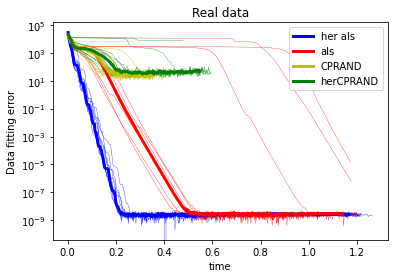

In [ ]:
list_err1=[]
list_time1=[]
list_err2=[]
list_time2=[]
list_err3=[]
list_time3=[]
list_err4=[]
list_time4=[]
min_e=None
for i in range(nb_rand) : 
 
  norm_tensor=tl.norm(t,2)
  if(min_e==None) : min_e=norm_tensor
  factors=random_init_fac(t,r)

  weights4,factors4,it4,error4,_,cpt,time4=her_CPRAND(t,r,n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=100,time_rec=True) 
  weights1,factors1,it1,error1,cpt,time1=her_Als(t,r,factors=copy.deepcopy(factors),it_max=500,time_rec=True) 
  weights3,factors3,it3,error3,_,time3=CPRAND(t,r,n_samples,factors=copy.deepcopy(factors),exact_err=True,it_max=500,err_it_max=100,time_rec=True) 
  weights2,factors2,it2,error2,time2=als(t,r,factors=copy.deepcopy(factors),it_max=500,time_rec=True) 
  error1=[i * norm_tensor for i in error1]
  del error1[0]
  error2=[i * norm_tensor for i in error2]
  del error2[0]
  error3=[i * norm_tensor for i in error3]
  del error3[0]
  error4=[i * norm_tensor for i in error4]
  del error4[0]
  
  if (min_e>min(min(error1),min(error2),min(error3),min(error4))) : min_e=min(min(error1),min(error2),min(error3),min(error4))
  list_err1.append(error1)
  list_err2.append(error2)
  list_err3.append(error3)
  list_err4.append(error4)
  list_time1.append(time1)
  list_time2.append(time2)
  list_time3.append(time3)
  list_time4.append(time4)
list_err1=np.array([np.array(i)  for i in list_err1])
list_err2=np.array([np.array(i)  for i in list_err2])
list_err3=np.array([np.array(i)  for i in list_err3])
list_err4=np.array([np.array(i)  for i in list_err4])
list_err1=list_err1-min_e
list_err2=list_err2-min_e
list_err3=list_err3-min_e
list_err4=list_err4-min_e
for i in range(len(list_err1)):
  plt.plot(np.cumsum(list_time1[i]),list_err1[i],'b-',linewidth=.3) 
for i in range(len(list_err2)):
  plt.plot(np.cumsum(list_time2[i]),list_err2[i],'r-',linewidth=.3) 
for i in range(len(list_err3)):
  plt.plot(np.cumsum(list_time3[i]),list_err3[i],'y-',linewidth=.3) 
for i in range(len(list_err4)):
  plt.plot(np.cumsum(list_time4[i]),list_err4[i],'g-',linewidth=.3) 
n_max1=len(max(list_err1, key=len)) # length of the longest error
n_max2=len(max(list_err2, key=len))
n_max3=len(max(list_err3, key=len))
n_max4=len(max(list_err4, key=len))
mat1=np.array([i.tolist() + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
mat2=np.array([i.tolist() + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
mat3=np.array([i.tolist() + [i[len(i)-1]]*(n_max3-len(i)) for i in list_err3])
mat4=np.array([i.tolist() + [i[len(i)-1]]*(n_max4-len(i)) for i in list_err4])


t_max1=len(max(list_time1, key=len))
t_max2=len(max(list_time2, key=len))
t_max3=len(max(list_time3, key=len))
t_max4=len(max(list_time4, key=len))
mat_time1=np.array([i + [0]*(t_max1-len(i)) for i in list_time1])
mat_time2=np.array([i + [0]*(t_max2-len(i)) for i in list_time2])
mat_time3=np.array([i + [0]*(t_max3-len(i)) for i in list_time3])
mat_time4=np.array([i + [0]*(t_max4-len(i)) for i in list_time4])
# plot

plt.plot(np.cumsum(np.median(mat_time1, axis=0)),np.median(mat1, axis=0),'b-',linewidth=3,label="her als") 
plt.plot(np.cumsum(np.median(mat_time2, axis=0)),np.median(mat2, axis=0),'r-',linewidth=3,label="als") 
plt.plot(np.cumsum(np.median(mat_time3, axis=0)),np.median(mat3, axis=0),'y-',linewidth=3,label="CPRAND") 
plt.plot(np.cumsum(np.median(mat_time4, axis=0)),np.median(mat4, axis=0),'g-',linewidth=3,label="herCPRAND") 
plt.yscale("log") 
plt.xlabel('time')
plt.ylabel('Data fitting error')
plt.legend(loc='best')
plt.title('Real data')